In [1]:
from scipy.spatial import distance as dist
import numpy as np
from imutils import contours
import imutils
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def midpoint(ptA, ptB):
    return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

In [3]:
def order_points(pts):
    xSorted = pts[np.argsort(pts[:, 0]), :]
    leftMost = xSorted[:2, :]
    rightMost = xSorted[2:, :]
    leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
    (tl, bl) = leftMost
    D = dist.cdist(tl[np.newaxis], rightMost, "euclidean")[0]
    (br, tr) = rightMost[np.argsort(D)[::-1], :]
    return np.array([tl, tr, br, bl], dtype="float32")

In [4]:
def spatial_filter(image, kernel):
    kernel_dim = kernel.shape[0]
    pad = (kernel_dim -1)//2
    img = cv2.copyMakeBorder(image.copy(),pad,pad,pad,pad,cv2.BORDER_CONSTANT,value=0)
    old_height, old_width = img.shape
    new_height, new_width = (old_height -kernel_dim +1, old_width-kernel_dim +1)
    new_img = np.zeros((new_height, new_width))
    for i in range(new_height):
        for j in range (new_width):
            new_img[i][j] = (np.sum(np.multiply(kernel, img[i:kernel_dim + i][:, j:kernel_dim + j])))  
    return new_img

In [25]:
image = cv2.imread('img/img2.jpg')
image = image[235:803,100:540]
# def img_resize(img):
#     if img.shape[0] >=2500 and img.shape[1]>=2500:
#         scale_percent = 10
#         width = int(img.shape[1] * scale_percent / 100)
#         height = int(img.shape[0] * scale_percent / 100) 
#         dim = (width, height) 
#         resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
#         return resized
#     else:
#         resized = cv2.resize(img, (int(img.shape[1]/2), int(img.shape[0]/2)), interpolation = cv2.INTER_AREA)
#         return resized
# resized_img = img_resize(image)

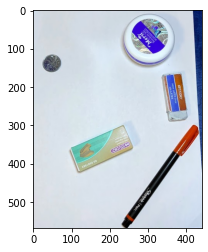

In [26]:
plt.imshow(image)

In [7]:
# rgb_planes = cv2.split(resized_img)

# result_planes = []
# result_norm_planes = []
# for plane in rgb_planes:
#     dilated_img = cv2.dilate(plane, np.ones((7,7), np.uint8))
#     bg_img = cv2.medianBlur(dilated_img, 21)
#     diff_img = 255 - cv2.absdiff(plane, bg_img)
#     norm_img = cv2.normalize(diff_img,None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
#     result_planes.append(diff_img)
#     result_norm_planes.append(norm_img)

# result = cv2.merge(result_planes)
# result_norm = cv2.merge(result_norm_planes)

In [8]:
# plt.imshow(result_norm)

In [9]:
# plt.imshow(thresh,'gray')

In [75]:
def get_contours_with_gaussian(img, thr=[50, 70]):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gau_kernel = cv2.getGaussianKernel(ksize=7, sigma=1)
#     img_blur = spatial_filter(img_gray, gau_kernel)
    img_blur = cv2.GaussianBlur(img_gray, (7, 7), 0)
    img_canny = cv2.Canny(img_blur, thr[0], thr[1])
#     img_canny = cv2.threshold(img_blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    kernel = np.ones((5,5))
    img_dia = cv2.dilate(img_canny, None, 2)
    img_thrld = cv2.erode(img_dia, None, 1)
    img_thrld = cv2.dilate(img_thrld, None, 1)
    contours = cv2.findContours(img_thrld.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    (final_contours, _) = imutils.contours.sort_contours(contours)
    plt.imshow(img_thrld, 'gray')
    return final_contours

In [31]:
def get_contours_with_median(img, thr=[180, 255]):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    dilated_img = cv2.dilate(img_gray, np.ones((15,15), np.uint8)) 
    bg_img = cv2.medianBlur(dilated_img, 21)
    diff_img = 255 - cv2.absdiff(img_gray, bg_img)
    norm_img = diff_img.copy() 
    cv2.normalize(diff_img, norm_img, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
    _, thr_img = cv2.threshold(norm_img, 230, 0, cv2.THRESH_TRUNC)
    cv2.normalize(thr_img, thr_img, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
    img_canny = cv2.Canny(thr_img, thr[0], thr[1])
    kernel = np.ones((5,5))
    img_dia = cv2.dilate(img_canny, kernel, 1)
    img_thrld = cv2.erode(img_dia, kernel, 1)
    contours = cv2.findContours(img_thrld.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    (final_contours, _) = imutils.contours.sort_contours(contours)
    plt.imshow(img_thrld, 'gray')
    return final_contours

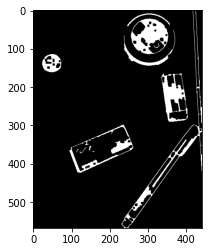

In [29]:
cntrs_median = get_contours_with_median(image)

5

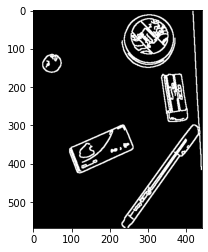

In [76]:
cntrs_gaussian = get_contours_with_gaussian(image, thr=[60, 110])
len(cntrs_gaussian)

In [38]:
colors = ((0, 0, 255), (240, 0, 159), (0, 165, 255), (255, 255, 0),(255, 0, 255))

In [37]:
def get_size(image, box, pixel_per_cm):
    (tl, tr, br, bl) = box
    mid_pt_horizontal = (tl[0] + int(abs(tr[0] - tl[0])/2), tl[1] + int(abs(tr[1] - tl[1])/2))
    mid_pt_verticle = (tr[0] + int(abs(tr[0] - br[0])/2), tr[1] + int(abs(tr[1] - br[1])/2))
    wid = dist.euclidean(tl, tr)/pixel_per_cm
    ht = dist.euclidean(tr, br)/pixel_per_cm
    cv2.putText(image, "{:.1f}cm".format(wid), (int(mid_pt_horizontal[0] - 15), int(mid_pt_horizontal[1] - 10)), 
    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
    cv2.putText(image, "{:.1f}cm".format(ht), (int(mid_pt_verticle[0] + 10), int(mid_pt_verticle[1])), 
    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

In [39]:
def get_distance(resizedImg, cnts, refObj_width, tune, refObj=None):

    for c in cnts:
        
        orig = resizedImg.copy()
#         orig = resizedImg
        
        if cv2.contourArea(c) < tune:
            continue
            
        box = cv2.minAreaRect(c)
        box = cv2.boxPoints(box)
        box = np.array(box)
    
        box = order_points(box)

        cX = np.average(box[:, 0])
        cY = np.average(box[:, 1])

        if refObj is None:
            (tl, tr, br, bl) = box
            (tlblX, tlblY) = midpoint(tl, bl)
            (trbrX, trbrY) = midpoint(tr, br)
            D = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))
            refObj = (box, (cX, cY), D / refObj_width) 

            continue
        
        
        cv2.drawContours(orig, [box.astype("int")], -1, (0, 255, 0), 2)
        cv2.drawContours(orig, [refObj[0].astype("int")], -1, (0, 255, 0), 2)

        refCoords = np.vstack([refObj[0], refObj[1]])
        objCoords = np.vstack([box, (cX, cY)])
    
        mid_pt_horizontal = (tl[0] + int(abs(tr[0] - tl[0])/2), tl[1] + int(abs(tr[1] - tl[1])/2))
        mid_pt_verticle = (tr[0] + int(abs(tr[0] - br[0])/2), tr[1] + int(abs(tr[1] - br[1])/2))
        wid = dist.euclidean(tl, tr)/refObj[2]
        ht = dist.euclidean(tr, br)/refObj[2]
        cv2.putText(orig, "{:.1f}cm".format(wid), (int(mid_pt_horizontal[0] - 15), int(mid_pt_horizontal[1] - 10)), 
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
        cv2.putText(orig, "{:.1f}cm".format(ht), (int(mid_pt_verticle[0] + 10), int(mid_pt_verticle[1])), 
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2) 
        
        get_size(orig, box, refObj[2]) 

#         for ((xA, yA), (xB, yB), color) in zip(refCoords, objCoords, colors):
#             cv2.circle(orig, (int(xA), int(yA)), 5, color, -1)
#             cv2.circle(orig, (int(xB), int(yB)), 5, color, -1)
#             cv2.line(orig, (int(xA), int(yA)), (int(xB), int(yB)), color, 2)
#             D = dist.euclidean((xA, yA), (xB, yB)) / refObj[2]
#             (mX, mY) = midpoint((xA, yA), (xB, yB))
#             cv2.putText(orig, "{:.1f}in".format(D), (int(mX), int(mY - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.55, color, 2)
        plt.figure(figsize=(12,10))
        plt.imshow(orig)
#     return orig

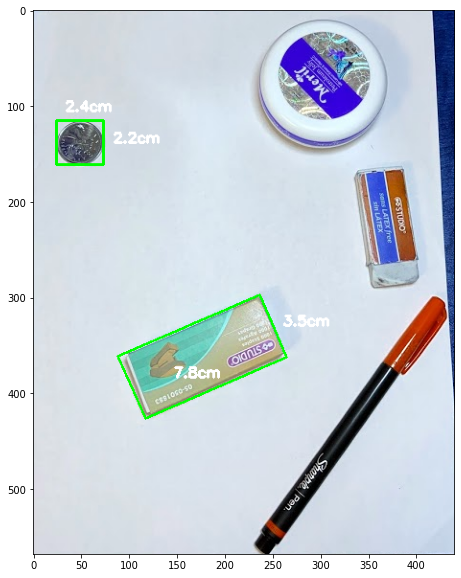

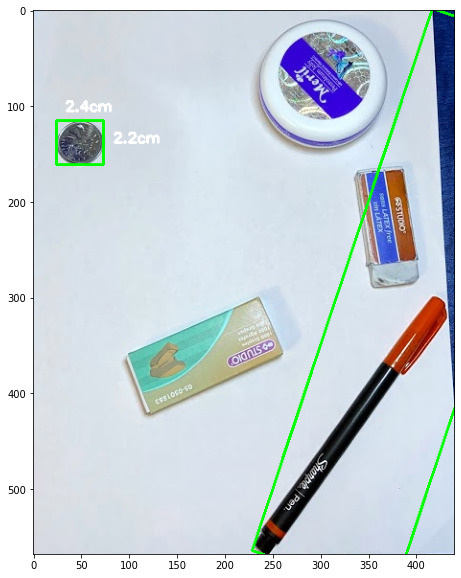

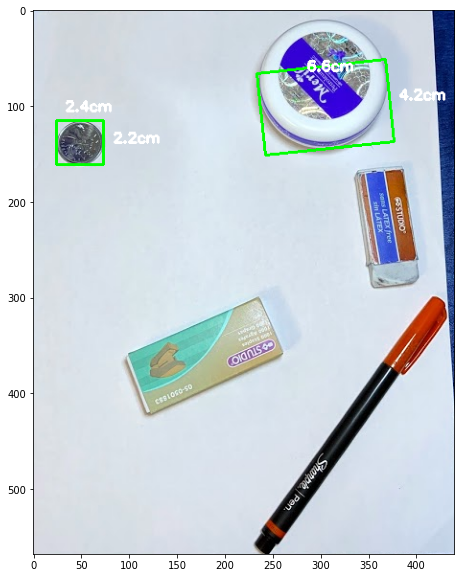

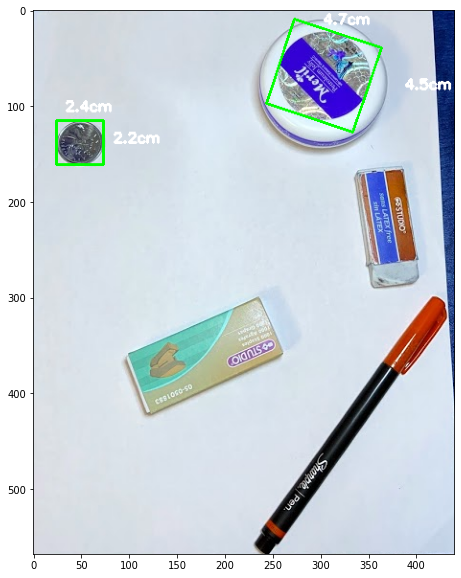

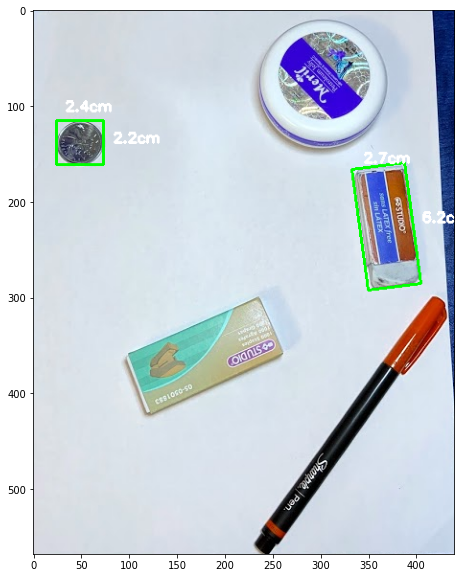

In [49]:
get_distance(image, cntrs_median, 2.388,tune=1000 )

************************************************************************************

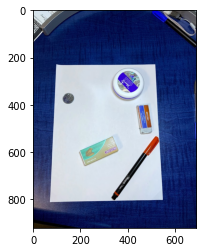

In [8]:
plt.imshow(image)

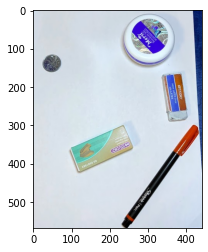

In [24]:
plt.imshow(image[235:803,100:540])

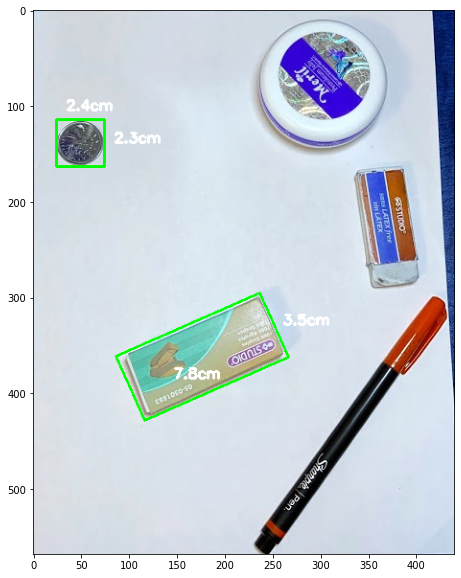

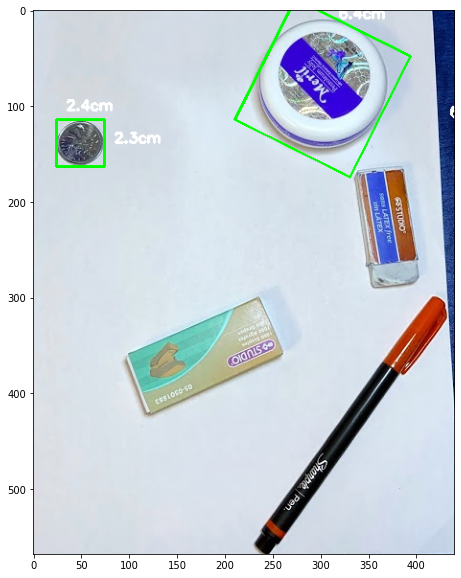

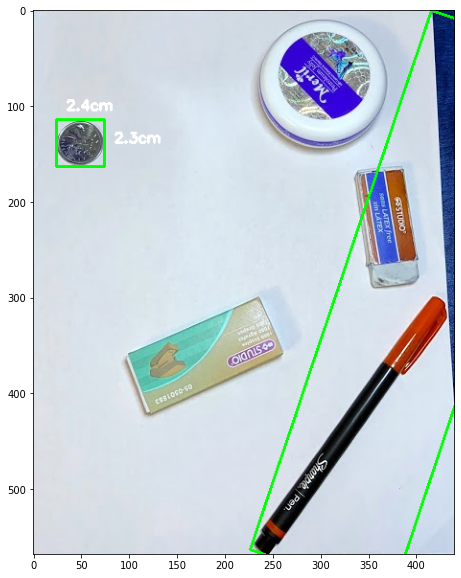

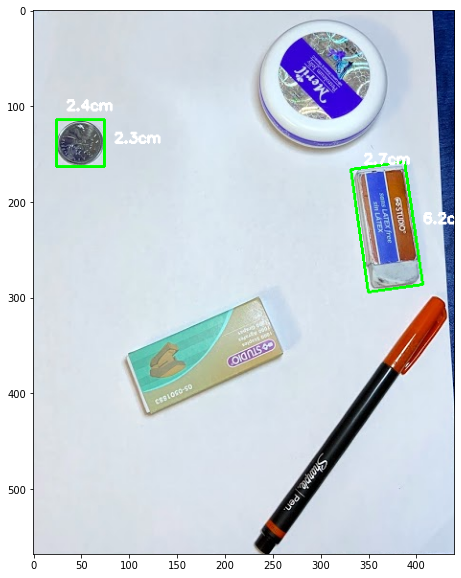

In [77]:
get_distance(image, cntrs_gaussian, 2.388, tune=100)

###########################################################################

In [20]:
image2 = cv2.imread('./image/eu_coin2.jpg')
ratio = image2.shape[0] / 500.0
orig = image2.copy()
image2 = imutils.resize(image2, height = 500)

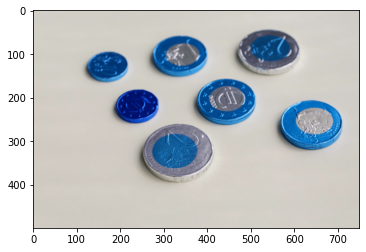

In [21]:
plt.imshow(image2)

In [22]:
gray = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (11, 11), 0)
edged = cv2.Canny(gray, 75, 200)

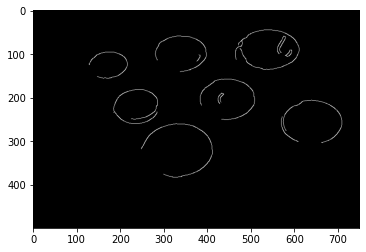

In [23]:
plt.imshow(edged, 'gray')

In [24]:
cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]

In [25]:
for c in cnts:
    # approximate the contour
    box = cv2.minAreaRect(c)
    box = cv2.boxPoints(box)
    box = np.array(box)
    cv2.drawContours(image2, [box.astype("int")], -1, (0, 255, 0), 2)
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    # if our approximated contour has four points, then we
    # can assume that we have found our screen
#     print(approx)
    if len(approx) == 4:
        screenCnt = approx
        break


In [26]:

cv2.drawContours(image2, [screenCnt], -1, (0, 255, 0), 2)

NameError: name 'screenCnt' is not defined

In [ ]:
plt.imshow(image2)

In [ ]:
def four_point_transform(image, pts):
	# obtain a consistent order of the points and unpack them
	# individually
	rect = order_points(pts)
	(tl, tr, br, bl) = rect
	# compute the width of the new image, which will be the
	# maximum distance between bottom-right and bottom-left
	# x-coordiates or the top-right and top-left x-coordinates
	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))
	# compute the height of the new image, which will be the
	# maximum distance between the top-right and bottom-right
	# y-coordinates or the top-left and bottom-left y-coordinates
	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))
	# now that we have the dimensions of the new image, construct
	# the set of destination points to obtain a "birds eye view",
	# (i.e. top-down view) of the image, again specifying points
	# in the top-left, top-right, bottom-right, and bottom-left
	# order
	dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")
	# compute the perspective transform matrix and then apply it
	M = cv2.getPerspectiveTransform(rect, dst)
	warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
	# return the warped image
	return warped

In [ ]:
warped = four_point_transform(image2, screenCnt.reshape(4, 2) * ratio)